In [1]:
import matplotlib.pyplot as plt
import scipy.io as sio
import pickle
import numpy as np

In [2]:
#load results stored in matlab
data = sio.loadmat('sensitivity_result_2.mat')
p = np.array(-data['price_summary'])
m = np.array(data['mitigation_summary'])
iteration = np.array(data['iteration_summary'])
u = np.array(-data['utility_summary'])
u_node = np.array(-data['utility_node_summary'])
norm = np.array(data['final_norm_g_QN_summary'])
fcount = np.array(data['fcount_summary'])

In [3]:
from tree import TreeModel

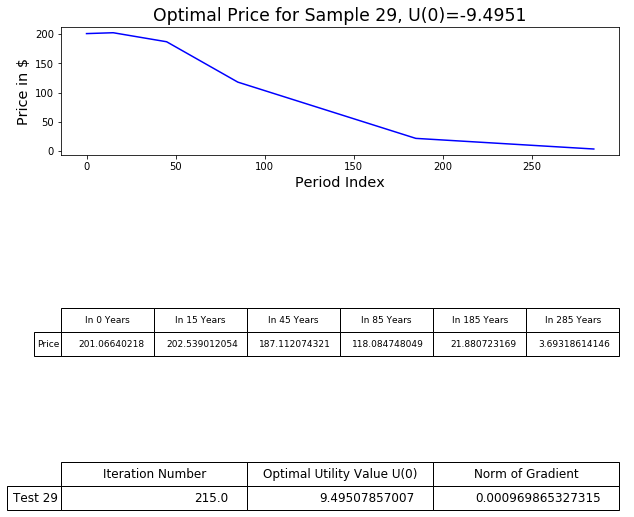

In [10]:
decision_times=[0, 15, 45, 85, 185, 285, 385]
period_price_ave = get_ave_price_ind(p, decision_times)

fig, (ax, tabay, tabax) = plt.subplots(nrows=3, figsize=(10,8))
ax.plot(#decision_times[:-1],list_min, 'r--', 
        #decision_times[:-1],list_max, 'r--',
        decision_times[:-1],period_price_ave,'b')
ax.set_title("Optimal Price for Sample 29, U(0)=-9.4951", size ='xx-large')
ax.set_ylabel('Price in $', size = 'x-large')
ax.set_xlabel('Period Index', size = 'x-large')

tabay.axis("off")
columns_price = ['In %d Years' %x for x in decision_times]
row_label_price = ['Price']
cell_text_price = np.zeros([1,len(period_price_ave)])
cell_text_price[0] = period_price_ave
the_table_price = tabay.table(cellText=cell_text_price,
                             rowLabels=row_label_price,
                             colLabels=columns_price)
the_table_price.set_fontsize(38)
the_table_price.scale(1,2)

tabax.axis("off")
columns = ['Iteration Number','Optimal Utility Value U(0)', 'Norm of Gradient']
row_label = ['Test 29']
cell_text = np.zeros([1,3])
cell_text[0] =[iteration[-1],utility[-1],norm[-1]]
the_table = tabax.table(cellText=cell_text,
                  rowLabels=row_label,
                  colLabels=columns,
                       loc = 'bottom')
the_table.set_fontsize(34)
the_table.scale(1, 2)

fig.savefig('Optimal Solution.eps',format='eps', dpi=1000, bbox_inches='tight')  
plt.show()

In [4]:
#base case
def get_ave_price(price,decision_times): #period average for each sample
    t = TreeModel(decision_times)
    nodes_index = []
    for i in range(t.num_periods):
        nodes_index.append(t.get_nodes_in_period(i)) #get nodes for slicing
    period_price_ave = np.zeros((price.shape[1], t.num_periods))
    for i in range(price.shape[1]):
        for j in range(t.num_periods):
            period_price_ave[i][j] = np.average(price[:,i][nodes_index[j][0]:nodes_index[j][1]+1])
    return period_price_ave

In [35]:
data_base = 'sensitivity_base_results.mat'
decision_times=[0, 15, 45, 85, 185, 285, 385]
period_price_ave = get_ave_price(data_base,decision_times)
total_period_ave = np.average(period_price_ave,0)

label = ['$ %d' %x for x in period_price_ave[0,:]]


NameError: name 'decision' is not defined

In [5]:
def get_90_quantile(period_price_ave):
    list0 = period_price_ave[:,0]
    list1 = period_price_ave[:,1]
    list2 = period_price_ave[:,2]
    list3 = period_price_ave[:,3]
    list4 = period_price_ave[:,4]
    list5 = period_price_ave[:,5]
    list_ = [list0,list1,list2,list3,list4,list5]
    fivepercent = int(len(list0)*0.05)
    for i in range(len(list_)):
        list_[i]=np.sort(list_[i])[fivepercent:-fivepercent] #take the 90% of the sorted results
    list_min = []
    list_max = []
    for i in list_:
        list_min.append(i[0])
        list_max.append(i[-1])   
    return list_min,list_max #take the lower and upper bounds for the test results

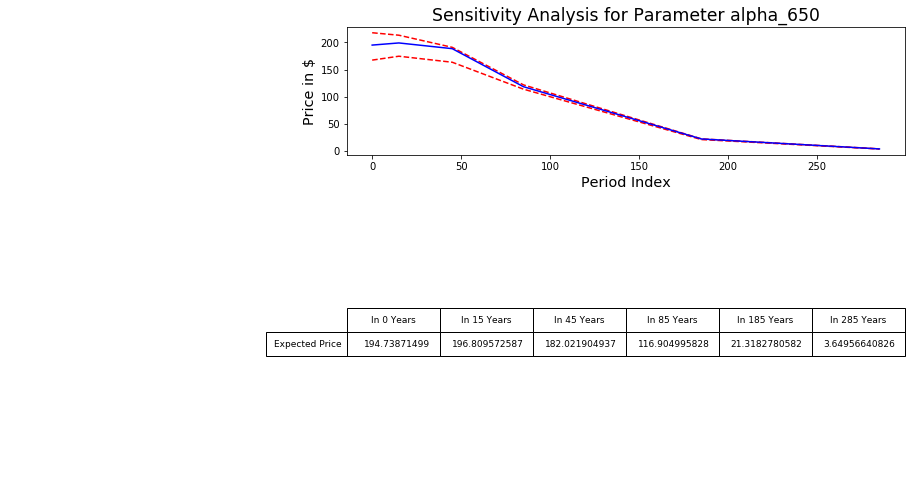

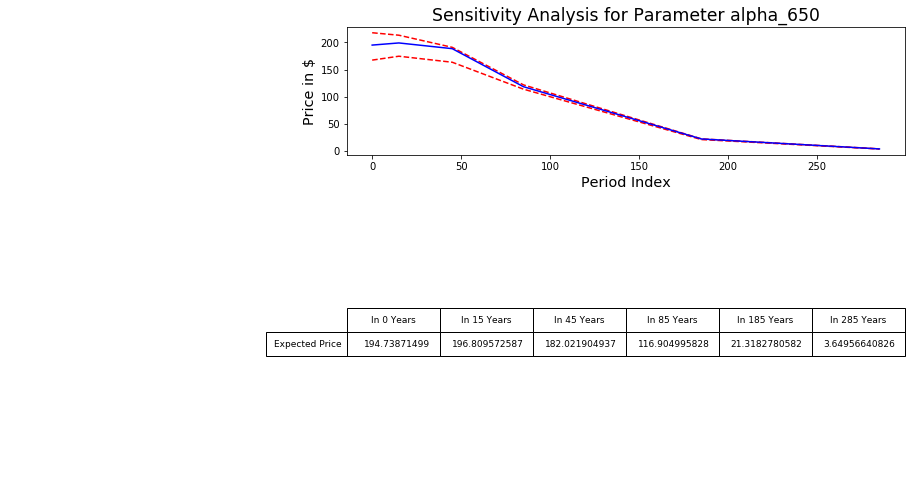

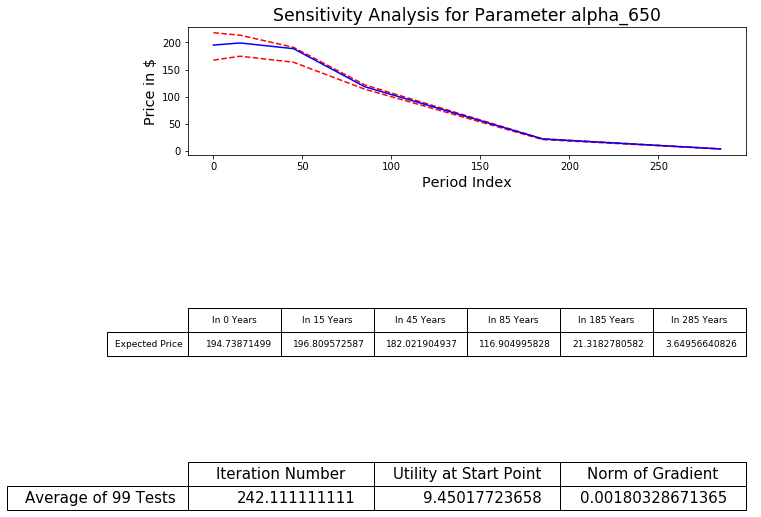

In [10]:
decision_times=[0, 15, 45, 85, 185, 285, 385]

period_price_ave = get_ave_price(p, decision_times)
list_min,list_max = get_90_quantile(period_price_ave)

fig, (ax, tabay, tabax) = plt.subplots(nrows=3, figsize=(10,8))
ax.plot(decision_times[:-1],list_min, 'r--', 
        decision_times[:-1],list_max, 'r--',
        decision_times[:-1],period_price_ave[0,:],'b')
ax.set_title("Sensitivity Analysis for Parameter alpha_650", size ='xx-large')
ax.set_ylabel('Price in $', size = 'x-large')
ax.set_xlabel('Period Index', size = 'x-large')

total_period_ave = np.average(period_price_ave,0)

tabay.axis("off")
columns_price = ['In %d Years' %x for x in decision_times]
row_label_price = ['Expected Price']
cell_text_price = np.zeros([1,len(total_period_ave)])
cell_text_price[0] = total_period_ave
the_table_price = tabay.table(cellText=cell_text_price,
                             rowLabels=row_label_price,
                             colLabels=columns_price)
the_table_price.set_fontsize(38)
the_table_price.scale(1,2)

tabax.axis("off")
columns = ['Iteration Number','Utility at Start Point', 'Norm of Gradient']
row_label = ['Average of %d Tests' %p.shape[1]]
rows = len(row_label)
cell_text = np.zeros([1,len(columns)])
#for row in range(len(norm)):
    #cell_text[row,:]=[iteration[row],u[row],norm[row]]
cell_text[0,:] = [np.average(iteration),np.average(u),np.average(norm)]
the_table = tabax.table(cellText=cell_text,
                  rowLabels=row_label,
                  #rowColours=colors,
                  colLabels=columns,
                       loc = 'bottom')
the_table.set_fontsize(34)
the_table.scale(1, 2)

fig.savefig('sensitivity_result_2_.eps',bbox_inches='tight')  
plt.show()

In [7]:
p.shape[1]

99